This file handles the selection, retrieval, and integration of data from multiple sources, 
serving as preparation for the final model training.



In [1]:
import os
import sys
import glob
import pickle
import warnings
from math import atan2, degrees
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
from rasterio.mask import mask
from pyproj import Transformer

warnings.filterwarnings("ignore", category=RuntimeWarning)

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from CoastSat.coastsat import SDS_tools
from tools import compute_shoreline_slope, build_transect_island_orientation, compute_ndvi_by_transect, build_final_dataset, compile_island_data


For `transect_types`, specifies whether `'radial'` or `'hybrid'` transects are used to record shoreline position data, which will later be assembled into the dataset.

In [2]:
# Choose transect type: 'radial' or 'hybrid'
transect_types = 'hybrid'

import sys
sys.path.append('../CoastSat/')
from data.sites import sites

# Sitename options: Madhirivaadhoo, Dhakendhoo, Funadhoo, Aidhoo, Mendhoo, Keyodhoo
sitename = 'Dhakendhoo'

In [3]:
site_info = sites[sitename]

lat_min, lat_max = site_info['lat_min'], site_info['lat_max']
lon_min, lon_max = site_info['lon_min'], site_info['lon_max']

print(f"Selected site: {sitename}")
print(f"Lat range: {lat_min} to {lat_max}")
print(f"Lon range: {lon_min} to {lon_max}")

Selected site: Dhakendhoo
Lat range: 5.247097 to 5.249889
Lon range: 72.890504 to 72.896411


## Extracting Transect Coordinates from the transect file

This section extracts the latitude and longitude coordinates of the transects from the transect file.


In [4]:
sys.path.append(os.path.abspath(".."))
from tools import export_shoreline_coords

export_shoreline_coords(sitename, transect_types)


Shoreline coordinates saved to ./Model_Data_Dhakendhoo/shoreline_coords.csv


In [5]:
transects_coords = []
transects_gdf = gpd.read_file(f"../CoastSat/data/{sitename}/{sitename}_{transect_types}_transects.geojson")

for idx, row in transects_gdf.iterrows():
    line = row.geometry
    midpoint = line.interpolate(0.5, normalized=True)
    transects_coords.append({
        "transect_id": row["name"],
        "longitude": midpoint.x,
        "latitude": midpoint.y
    })

df_coords = pd.DataFrame(transects_coords)
df_coords.to_csv(f"./Model_Data_{sitename}/transects_coords.csv", index=False)

print("Midpoints saved to 'Model_Data/transects_coords.csv'")

Midpoints saved to 'Model_Data/transects_coords.csv'


# Accessing DEM Data from NASADEM

This section describes how to access Digital Elevation Model (DEM) data from the NASADEM dataset.
NASADEM Website: https://www.earthdata.nasa.gov/topics/land-surface/digital-elevation-terrain-model-dem

Please ensure that the latitude and longitude values in the code below are updated to match those of the island used in the `example_jupyter.py` file of CoastSat.


In [6]:
import requests

url = "https://portal.opentopography.org/API/globaldem"
params = {
    "demtype": "NASADEM",
    "south": lat_min,
    "north": lat_max,
    "west": lon_min,
    "east": lon_max,
    "outputFormat": "GTiff",
    "API_Key": "demoapikeyot2022"
}


response = requests.get(url, params=params)

if response.status_code == 200:
    with open("nasadem.tif", "wb") as f:
        f.write(response.content)
    print("✅ downloaded nasadem.tif successfully")
else:
    print("❌ download failed with status code:", response.status_code)
    print(response.text)


✅ downloaded nasadem.tif successfully


Check and validate the downloaded Digital Elevation Model (DEM) data.

CRS: EPSG:4326
Bounds: BoundingBox(left=72.89041666670013, bottom=5.247361111103702, right=72.89625000003346, top=5.25013888888148)
Resolution: (0.0002777777777778147, 0.0002777777777778147)
Width x Height: 21 x 10
Data Type: int16
Nodata Value: -32768.0

Min: 0
Max: 10
Mean: 3.2142857142857144
Nodata pixels: 0 / 210
Unique values in DEM: [ 0  1  3  4  5  6  7  8  9 10]


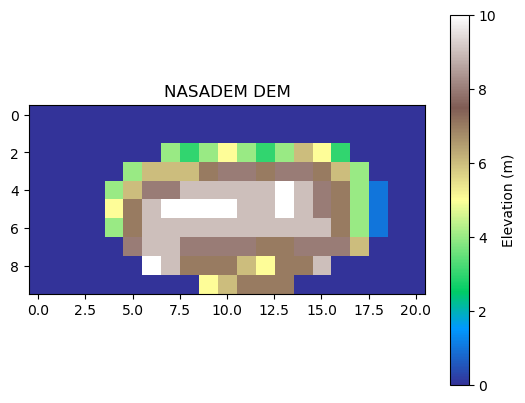

In [7]:
with rasterio.open("nasadem.tif") as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Resolution:", src.res)
    print("Width x Height:", src.width, "x", src.height)
    print("Data Type:", src.dtypes[0])
    print("Nodata Value:", src.nodata)


with rasterio.open("nasadem.tif") as src:
    data = src.read(1)
    
nodata = src.nodata

# view basic statistics
print("\nMin:", np.nanmin(data))
print("Max:", np.nanmax(data))
print("Mean:", np.nanmean(data))

# view nodata count
nodata_count = np.sum(data == nodata)
total_pixels = data.size
print("Nodata pixels:", nodata_count, "/", total_pixels)

unique_vals = np.unique(data)
print("Unique values in DEM:", unique_vals[:20])  # print first 20 unique values

plt.imshow(data, cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.title("NASADEM DEM")
plt.show()



In [8]:
df_slope = compute_shoreline_slope(sitename=sitename, transects_gdf=transects_gdf)

Shoreline 37.78 too close for T1 on 2016-04-22 05:37:18+00:00.
Shoreline 36.91 too close for T1 on 2020-06-15 05:37:44+00:00.
Shoreline 34.15 too close for T1 on 2024-02-20 05:37:39+00:00.
Shoreline 22.90 too close for T10 on 2018-11-28 05:37:33+00:00.
Shoreline 25.49 too close for T11 on 2016-04-22 05:37:18+00:00.
Shoreline 39.72 too close for T11 on 2016-06-11 05:37:19+00:00.
Shoreline 32.06 too close for T11 on 2016-07-11 05:37:19+00:00.
Shoreline 39.24 too close for T11 on 2016-09-29 05:37:11+00:00.
Shoreline 38.66 too close for T11 on 2017-05-27 05:37:19+00:00.
Shoreline 38.94 too close for T11 on 2017-07-11 05:37:16+00:00.
Shoreline 36.72 too close for T11 on 2017-07-16 05:37:17+00:00.
Shoreline 34.32 too close for T11 on 2017-07-26 05:37:17+00:00.
Shoreline 36.30 too close for T11 on 2017-08-25 05:37:17+00:00.
Shoreline 35.87 too close for T11 on 2017-09-14 05:37:13+00:00.
Shoreline 39.68 too close for T11 on 2017-09-24 05:37:12+00:00.
Shoreline 36.81 too close for T11 on 2018-0

**Note:** From this point onward, it may be observed that the shorelines extracted by CoastSat sometimes lack transect position data at certain time steps. This is understandable, as cloud cover below the threshold can occasionally obstruct the imagery.

In the DEM data, an elevation value of `-32768.0` indicates **NoData** for that point, meaning the location falls over the sea where no elevation data is available.


# Calculation of Geographical Features: Area, Perimeter, and Compactness

In [9]:
polygon = [[[lon_min, lat_min],
            [lon_max, lat_min],
            [lon_max, lat_max],
            [lon_min, lat_max],
            [lon_min, lat_min]]]
     
polygon = SDS_tools.smallest_rectangle(polygon)

dates = ['2016-01-01', '2024-12-31']
sat_list = ['L8','L9','S2']

filepath = os.path.join(os.getcwd(), '..', 'CoastSat', 'data')
with open(os.path.join(filepath, sitename, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)

output = SDS_tools.remove_duplicates(output)
output = SDS_tools.remove_inaccurate_georef(output, 10)

14 duplicates
5 bad georef


**Note on Duplicate Observations**

Please note that only duplicate entries from the **same satellite at the same timestamp** have been removed so far. Duplicates from **different satellites at the same timestamp** have not yet been filtered.

Both datasets are retained for now, and an average will be calculated later.


In [10]:
build_transect_island_orientation(output, sitename)


Saved transects_island_orientation.csv -> ./Model_Data_Dhakendhoo/transects_island_orientation.csv


,date,transect_id,island_orientation
0,2016-01-03,T1,177.925850
1,2016-01-03,T2,177.925850
2,2016-01-03,T3,177.925850
3,2016-01-03,T4,177.925850
4,2016-01-03,T5,177.925850
...,...,...,...
6531,2024-12-26,T15,177.638077
6532,2024-12-26,T16,177.638077
6533,2024-12-26,T17,177.638077
6534,2024-12-26,T18,177.638077


# Calculate NDVI value from satellite data

In [11]:
compute_ndvi_by_transect(sitename, lon_min, lat_min, lon_max, lat_max, tolerance_days=5)

Found 737 image files
✅ Saved NDVI-by-transect file with ±5 days tolerance: ./Model_Data_Dhakendhoo/ndvi.csv
✅ NDVI coverage: 86/314 dates (27.39%) have valid NDVI values.


(            date transect_id  NDVI
 0     2016-01-03          T1   NaN
 1     2016-01-03          T2   NaN
 2     2016-01-03          T3   NaN
 3     2016-01-03          T4   NaN
 4     2016-01-03          T5   NaN
 ...          ...         ...   ...
 6151  2024-12-26         T15   NaN
 6152  2024-12-26         T16   NaN
 6153  2024-12-26         T17   NaN
 6154  2024-12-26         T18   NaN
 6155  2024-12-26         T19   NaN
 
 [6156 rows x 3 columns],
 {'total_dates': 314,
  'valid_dates': np.int64(86),
  'coverage_pct': np.float64(27.388535031847134)})

# Assemble all data

The following code will assemble data from all sources.

Before proceeding with the following operations, please first navigate to the `ECMWF.ipynb` file and the `Reef_Geomorphometrics.ipynb` file to get the wind, wave and reef platform data.


In [12]:
df_final, outpath = build_final_dataset(
    sitename=sitename,
    transect_types=transect_types
)

print("Final dataset saved to:", outpath)


Final dataset saved to: ./Model_Data_Dhakendhoo/final_data_supplemented.csv


# Experiment Preparation
Division of training and prediction data for different experiments. Uncomment and run the code below once all datasets are ready. If you prefer not to manually assemble the data, you can view the prepared datasets in the `Modelling/data` folder and run `Modelling/notebook/run_models.ipynb` directly to see an example execution.


**Experiment 1**  
The code below is used to compile data from all island samples for experiments predicting shoreline segments across islands and over all time periods.

In [ ]:
# site_options = ['Madhirivaadhoo', 'Dhakendhoo', 'Funadhoo', 'Aidhoo', 'Mendhoo','Keyodhoo']
# output_path = f'../Modelling/data/final_data_supplemented_total_{transect_types}.csv'
# compile_island_data(site_options, output_path)

Compiled dataset saved to ../Modelling/data/final_data_supplemented_total_hybrid.csv


**Experiment 2:**  
Train on random five islands and predict on another island


In [ ]:
# island_train = ['Madhirivaadhoo', 'Dhakendhoo', 'Funadhoo', 'Aidhoo','Mendhoo']
# island_prediction = ['Keyodhoo']

# output_train = f'../Modelling/data/final_data_supplemented_total_{transect_types}_train.csv'
# output_prediction = f'../Modelling/data/final_data_supplemented_total_{transect_types}_prediction.csv'
# compile_island_data(island_train, output_train)
# compile_island_data(island_prediction, output_prediction)

Compiled dataset saved to ../Modelling/data/final_data_supplemented_total_hybrid_train.csv
Compiled dataset saved to ../Modelling/data/final_data_supplemented_total_hybrid_prediction.csv


**Experiment 3:**  
Split training and prediction data by year, using 2024 as the prediction dataset, and 2016-2023 as the training dataset.


In [ ]:
# file_path = f'../Modelling/data/final_data_supplemented_total_{transect_types}.csv'
# df = pd.read_csv(file_path)

# df['date'] = pd.to_datetime(df['date'])
# df_2024 = df[df['date'].dt.year == 2024]
# df_2016_2023 = df[df['date'].dt.year != 2024]

# df_2024.to_csv(f'../Modelling/data/final_data_supplemented_total_2024_{transect_types}.csv', index=False)
# df_2016_2023.to_csv(f'../Modelling/data/final_data_supplemented_total_2016-2023_{transect_types}.csv', index=False)

# print("Data successfully split and saved into separate files!")

Data successfully split and saved into separate files!
